In [20]:
from tool import *
from IPython import display
import random
import torch

In [21]:
class Model_action(torch.nn.Module):
    def __init__(self):
        super(Model_action, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(4, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2),
            torch.nn.Softmax(dim=1),
        )

    def forward(self, state):
        return self.fc(state)  # Shape: [batch_size, num_actions]
    
class Model_value(torch.nn.Module):
    def __init__(self):
        super(Model_value, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(4, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
        )

    def forward(self, state):
        return self.fc(state)  # Shape: [batch_size, num_actions]
    
# Initialize Models
model_action = Model_action()
model_value = Model_value()
model_action(torch.randn(2, 4)), model_value(torch.randn(2, 4))

(tensor([[0.4947, 0.5053],
         [0.4840, 0.5160]], grad_fn=<SoftmaxBackward0>),
 tensor([[-0.0345],
         [-0.0144]], grad_fn=<AddmmBackward0>))

In [22]:
def play(show=False):
    state = []
    action = []
    reward = []
    next_state = []
    over = []

    s = env.reset()
    o = False
    while not o:
        #根据概率采样
        prob = model_action(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
        a = random.choices(range(2), weights=prob, k=1)[0]

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)
        next_state.append(ns)
        over.append(o)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state).reshape(-1, 4)
    action = torch.LongTensor(action).reshape(-1, 1)
    reward = torch.FloatTensor(reward).reshape(-1, 1)
    next_state = torch.FloatTensor(next_state).reshape(-1, 4)
    over = torch.LongTensor(over).reshape(-1, 1)

    return state, action, reward, next_state, over, reward.sum().item()


state, action, reward, next_state, over, reward_sum = play()

reward_sum

-970.0

In [23]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=1e-3)
optimizer_value = torch.optim.Adam(model_value.parameters(), lr=1e-2)


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)

In [24]:
def train_value(state, reward, next_state, over):
    requires_grad(model_action, False)
    requires_grad(model_value, True)

    #计算target
    with torch.no_grad():
        target = model_value(next_state)
    target = target * 0.98 * (1 - over) + reward

    #每批数据反复训练10次
    for _ in range(10):
        #计算value
        value = model_value(state)

        loss = torch.nn.functional.mse_loss(value, target)
        loss.backward()
        optimizer_value.step()
        optimizer_value.zero_grad()

    #减去value相当于去基线
    return (target - value).detach()


value = train_value(state, reward, next_state, over)

value.shape

torch.Size([31, 1])

In [25]:
def train_action(state, action, value):
    requires_grad(model_action, True)
    requires_grad(model_value, False)

    delta = []
    for i in range(len(value)):
        s = 0
        for j in range(i, len(value)):
            s += value[j] * (0.98 * 0.95)**(j - i)
        delta.append(s)
    delta = torch.FloatTensor(delta).reshape(-1, 1)

    with torch.no_grad():
        prob_old = model_action(state).gather(dim=1, index=action)

    #每批数据反复训练10次
    for _ in range(10):
        prob_new = model_action(state).gather(dim=1, index=action)

        ratio = prob_new / prob_old
        surr1 = ratio * delta
        surr2 = ratio.clamp(0.8, 1.2) * delta

        loss = -torch.min(surr1, surr2).mean()

        loss.backward()
        optimizer_action.step()
        optimizer_action.zero_grad()

    return loss.item()


train_action(state, action, value)

367.06585693359375

In [26]:
def train():
    model_action.train()
    model_value.train()

    #训练N局
    for epoch in range(1000):
        #一个epoch最少玩N步
        steps = 0
        while steps < 200:
            state, action, reward, next_state, over, _ = play()
            steps += len(state)

            #训练两个模型
            delta = train_value(state, reward, next_state, over)
            loss = train_action(state, action, delta)

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss, test_result)


train()

0 -42.725372314453125 -970.75
100 10.217211723327637 200.0
200 -12.715615272521973 200.0
300 -11.653631210327148 200.0
400 -10.245566368103027 200.0
500 -24.635398864746094 -513.05
600 -7.788021087646484 200.0
700 -6.628324508666992 200.0
800 -5.023984909057617 200.0
900 -4.264517784118652 200.0


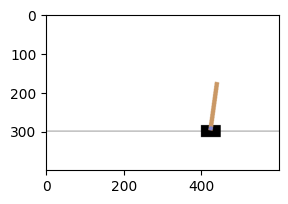

200.0

In [27]:
play(True)[-1]